## Pulling ASO from SnowEx database

This code was built from the SnowEx hackweek database tutorial

### Import stuff to work with database and rasters:

In [ ]:
# Import the function to get connect to the db
from snowexsql.db import get_db

# Import our class for the points table
from snowexsql.data import ImageData

# import this to use define sql functions (e.g. postgis!)
from sqlalchemy.sql import func 

# Import this to convert to a rasterio object for easy plotting
from snowexsql.conversions import raster_to_rasterio 

# Import a convenient function to plot with 
from rasterio.plot import show

# Import
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc

import geopandas as gpd

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

In [2]:
# Import the function to investigate a table
from snowexsql.db import get_table_attributes

# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(ImageData)

# Print out the results nicely
print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))

These are the available columns in the table:
 
* date
* date_accessed
* description
* doi
* instrument
* metadata
* observers
* raster
* registry
* site_name
* time_created
* time_updated
* type
* units



### What to filter?

In [3]:
# This is what you will use for all of hackweek to access the db
engine, session = get_db(db_name)

# Get the unique datanames in the table
results = session.query(ImageData.type).distinct().all()
print('Available types = {}'.format(', '.join([r[0] for r in results])))

# Get the unique instrument in the table
results = session.query(ImageData.instrument).distinct().all()
print('\nAvailable Instruments = {}'.format(', '.join([str(r[0]) for r in results])))

# Get the unique dates in the table
results = session.query(ImageData.date).distinct().all()
print('\nAvailable Dates = {}'.format(', '.join([str(r[0]) for r in results])))

# Get the unique sites in the table
results = session.query(ImageData.site_name).distinct().all()
print('\nAvailable sites = {}'.format(', '.join([str(r[0]) for r in results])))

session.close()

Available types = swe, DEM, insar amplitude, insar correlation, depth, insar interferogram real, insar interferogram imaginary

Available Instruments = UAVSAR, L-band InSAR, lidar

Available Dates = 2020-02-13, None, 2020-02-21, 2020-02-12, 2020-01-31, 2020-02-01, 2020-02-02, 2020-03-11

Available sites = None, idaho, Grand Mesa


### Query

In [ ]:
# Read in shapefile
#shp = gpd.read_file(

# Grab a session
engine, session = get_db(db_name)

# 3. Merge all the tiles together, note gfunc vs func. This is because ST_Union exists in two places in postgis for geom and rasters!
base = gfunc.ST_Union(ImageData.raster, _type=Raster)

# 4. Get the merged result as a geotiff! 
base = func.ST_AsTiff(base)

# 5. Filter by lidar data
qry = session.query(base).filter(ImageData.instrument == 'lidar')

# 7. Get rasters within shapefile
#qry = qry.filter(func.ST_Within(SiteData.geom, shp))

print(qry.count())

# 8. Execute, convert and plot! 
result = qry.all()
datasets = raster_to_rasterio(session, result)
show(datasets[0], vmin=-0.02, vmax=0.02, cmap='Purples')

session.close()



/tmp/ipykernel_3854/3017861645.py:15: SAWarning: UserDefinedType Geometry(geometry_type='POINT') will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  point = session.query(SiteData.geom).filter(SiteData.site_id == site_id).distinct().all()[0][0]


1


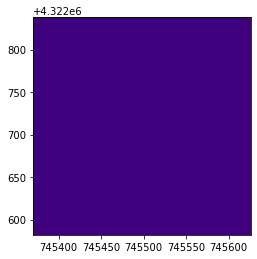

In [9]:
# import our pits metadata table class
from snowexsql.data import SiteData
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc

# Grab a session
engine, session = get_db(db_name)

# session.rollback()

# 1. Lets choose a site we want to grab a raster tile
site_id = '5S31'

# 2. Get the location of the pit, POSTGIS functions like to work in the text format of things so convert the point geom to text which is also in binary in the db   
point = session.query(SiteData.geom).filter(SiteData.site_id == site_id).distinct().all()[0][0]

# 3. Merge all the tiles together, note gfunc vs func. This is because ST_Union exists in two places in postgis for geom and rasters!
base = gfunc.ST_Union(ImageData.raster, _type=Raster)

# 4. Get the merged result as a geotiff! 
base = func.ST_AsTiff(base)

# 5. Filter by lidar data
qry = session.query(base).filter(ImageData.type == 'DEM')

# 7. Isolate tiles touching the pit location
qry = qry.filter(func.ST_Intersects(ImageData.raster, point))

print(qry.count())

# 8. Execute, convert and plot! 
result = qry.all()
datasets = raster_to_rasterio(session, result)
show(datasets[0], vmin=-0.02, vmax=0.02, cmap='Purples')

session.close()